In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense


## Data Generating Process Description 

- In the simulation, we wish to simulate a very simple case of both exposure model and the outcome model.

In [33]:
def mySoftMax(arr):
    num = np.exp(arr)
    denom = np.sum(num)
    return num/denom


def naive_est(res):
    treat_res = [elm[0] for elm in res[0]]
    control_res = [elm[1] for elm in res[0]]
    return np.mean(treat_res) - np.mean(control_res)


def dim_est(obs_T, obs_C):
    n1,n0 = len(obs_T), len(obs_C)
    return np.mean(obs_T) -np.mean(obs_C), np.sqrt(np.var(obs_T)/n1 + np.var(obs_C) / n0)


def point_est(all_treat_array, all_control_array):
    mus_T, mus_C  = all_treat_array[:, 11:21], all_control_array[:,11:21]
    p_T, p_C  = all_treat_array[:, 21:], all_control_array[:,21:]
    return np.mean(np.sum((mus_T * (p_T - p_C)), axis = 1 ))


def naive_dim_estimate(vector_T, vector_C):
    return np.mean(vector_T) - np.mean(vector_C), np.var(vector_T)/len(vector_T) + np.var(vector_C) / len(vector_C)

def debias_estimator(Hfuncs, influence_funcs):
    tau_hat = np.mean(Hfuncs - influence_funcs)
    return tau_hat, np.mean((influence_funcs - tau_hat)**2) / len(influence_funcs)

In [34]:
## Number of videos 
J = 1000 
## Consideration set size 
K = 10 
k=10
## Generate some queries along with the recommendation model 
Q = 10000


def permute_treatment_dict(J):
    perm_dict = {}
    for j in range(J):
        perm_dict[j] = np.random.choice([True,False], 1)
    return perm_dict

In [8]:
## True Model 

class MyModel_True:
    def __init__(self, k, num_treats,promo_ratio):

        self.k = k
        self.promo_ratio = promo_ratio
        self.num_treats = num_treats

    def predict(self,inputs):
        split_structure =  [1]+ [1] + [1] * self.num_treats + [1]
        splitted_elements = tf.split(inputs, split_structure, axis=2)
        X_utility =  np.squeeze(np.array(splitted_elements[1]), axis=2)
        X_goodbads = np.squeeze(np.array(splitted_elements[0]), axis = 2)

        W_matrix =  np.squeeze(np.array(splitted_elements[2]), axis =2 )

        final_score_matrix = (1 + W_matrix * self.promo_ratio * X_goodbads) * X_utility

        ## First element of each row 
        first_elm = X_utility[:,0]
        minus_matrix = first_elm.reshape((len(first_elm),1))@np.ones((1,K))
        final_score_matrix = final_score_matrix - minus_matrix

        X_logit = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix)
        return X_logit

In [9]:
## Modifying the tensor for 3d input 
class MyModel_multiple_simple_layers_0911(Model):
    def __init__(self, k, num_treats,predictY=False):
        super(MyModel_multiple_simple_layers_0911, self).__init__()
        self.k = k
        self.num_treats = num_treats
        self.groupNames = ['A'] + ['B' + str(i+1) for i in range(self.num_treats)]
        
        self.baseline_logit = Dense( 1, activation = "linear")
        self.logit_dense_layer = {} 
        for g in self.groupNames:
            self.logit_dense_layer[g] = Dense(1, activation = "linear")
        self.common_hidden = Dense(3, activation = "linear")
        self.softmax = Dense(k, activation='softmax')
        
        self.predictY = predictY
        self.d5 = Dense(self.k, activation = "relu")
        self.doutcome = Dense(1)
        
        self.d_onehot = tf.keras.layers.Lambda(lambda x: tf.one_hot(tf.argmax(x, axis=-1), k))
        
    
    def call(self, inputs):

        split_structure =  [2] + [1] * self.num_treats + [1]
        splitted_elements = tf.split(inputs, split_structure, axis=2)
        x1 = splitted_elements[0]
        ypredicts = splitted_elements[-1]
        
        
        
        
        ## Step 1: Reshape the input 
        
        reshape_x1 = tf.reshape(x1, (-1, x1.shape[-1]))
        
        ## Step 2: a common hidden layer
        x1_common_hidden = self.common_hidden(reshape_x1)
        
        #x1_common_hidden_3d = tf.reshape(x1_common_hidden, [x1.shape[0],self.k, x1_common_hidden.shape[1]])
        x1_common_hidden_3d = tf.reshape(x1_common_hidden,[-1, k, 3])
        
        ## Baseline logit
        x1_final = self.baseline_logit(x1_common_hidden_3d)
        
        # Get the first element of the second dimension
        first_element = x1_final[:, 0:1, :]

        # Subtract the first element from every element of the second dimension
        x1_final = x1_final - first_element

        
        ## Step 3: logit model
        for i in range(self.num_treats):
            w_g = splitted_elements[i + 1]
            xg_hidden = self.logit_dense_layer['B'+str(i+1)](x1_common_hidden_3d)
            x1_final = tf.add(tf.multiply(w_g, xg_hidden), x1_final)
            
        ## Step 4: Softmax
        reshaped_data = tf.squeeze(x1_final, axis=-1)
        softmax_p =  self.softmax(reshaped_data)

        # for g in self.groupNames:
        #     if g != 'A':
        #         w_g = self.treatment_matrix_dict[g]
        #         x = tf.math.add(tf.multiply(w_g, self.logit_dense_layer[g](x1)), x)
        #x = tf.add(tf.multiply(self.treatment_matrix_dict['B1'],  x2_hidden), x1_hidden)

        # x = tf.mul( w, x1_hidden)

        y1 = self.d_onehot(softmax_p)
        
        if self.predictY:
            x5 = self.d5(x1)
            y2 = self.doutcome(tf.multiply(softmax_p, x5))
        else:
            
            ypredicts = splitted_elements[-1]
            ypredicts = tf.squeeze(ypredicts, axis=-1)
            
            y2 = tf.reduce_sum(tf.multiply(softmax_p, ypredicts), axis = 1 )
            y2 = tf.expand_dims(y2, axis=-1)

            
        # ## One hot vector  
        # y1 = softmax_p
        # x5 = self.d5(ypredicts)
        # print("softmax shape", y1.shape)
        
        # ## Outcome 
    
        # y2 = self.doutcome(tf.multiply(y1, x5))
        


        res = tf.concat([softmax_p,y2], axis=1)
        return res

# Define custom loss function
def custom_loss(y_true, y_pred):

    y1_true, y2_true = tf.split(y_true, [k, k], axis=1)
    y1_pred, y2_pred = tf.split(y_pred, [k, 1], axis=1)


    loss1 = tf.keras.losses.BinaryCrossentropy()(y1_true, y1_pred)
    #loss2 = tf.keras.losses.MeanSquaredError()(y2_true, y2_pred)
    return loss1 
    

In [11]:

## True Exposure Model and Data Generating Process 
from scipy.special import expit
def logistic_row(row):
    return expit(row) / np.sum(expit(row))





# I. deterministic: 
# selected_indices = np.argmax(X_logit, axis = 1)
# II. random choice for exposure 


def DGP(promo_rat):
    good_bad_dict = {} 
    treatment_dict = {} 
    utility_score = {} 
    for j in range(J):
        good_bad_dict[j] = np.random.choice([True,False], 1)
        treatment_dict[j] = np.random.choice([True,False], 1)
        utility_score[j] = np.random.uniform()
    X_goodbads = []
    X_utility = []
    W_matrix = []
    query_matrix = []
    promo_ratio = promo_rat
    for each_query in range(Q):
        ## Form the consideration set 
        selected_indices = np.random.choice(np.arange(J), K, replace= False)
        query_matrix += [selected_indices]
        X_goodbads = np.append(X_goodbads,[good_bad_dict[ind] for ind in selected_indices])
        X_utility = np.append(X_utility, [utility_score[ind] for ind in selected_indices])
        W_matrix = np.append(W_matrix, [treatment_dict[ind] for ind in selected_indices])
    X_goodbads = X_goodbads.reshape(Q, K)
    X_utility = X_utility.reshape(Q, K)
    W_matrix = W_matrix.reshape(Q,K)
    final_score_matrix = (1 + W_matrix * promo_ratio * X_goodbads) * X_utility

    X_logit = np.apply_along_axis(logistic_row, axis=1, arr=final_score_matrix)
    expose_indices = np.array([np.random.choice(np.arange(10), size = 1, p = X_logit[i,:]) for i in range(Q)])
    inddds = np.array(list(np.arange(K)) * Q).reshape(Q,K)
    exposure_matrix = np.array([inddds[i,:] == expose_indices[i] for i in range(Q)])

    ## Outcome model  
    ## First: a true outcome model of Exponential 
    outcome_potential = np.random.normal(size=(Q, K)) +  X_goodbads

    return query_matrix,X_goodbads,X_utility,W_matrix, exposure_matrix, outcome_potential



In [13]:
## True Outcome Model test 
dim_B, dim_var_B= [],[]
debias_B, debias_var_B = [],[] 
undebias_B, debias_var_old_B = [],[]
truth= []
B = 100
for b in range(B):
    if b % 5 == 0:
        print(b)

    training_ratio = 0.4
 
    uplift_ratio = 0
    ## DGP and data pre-processing 
    query_matrix,X_goodbads,X_utility,W_matrix, exposure_matrix, outcome_potential = DGP(uplift_ratio)
    query_train, query_test = np.array(query_matrix)[:int(training_ratio * Q),:], np.array(query_matrix)[int(training_ratio * Q):,:]
    X_goodbads_train, X_goodbads_test = X_goodbads[:int(training_ratio * Q),:], X_goodbads[int(training_ratio * Q):,:]
    X_utility_train, X_utility_test =  X_utility[:int(training_ratio* Q),:], X_utility[int(training_ratio * Q):,:]
    W_matrix_train, W_matrix_test = W_matrix[:int(training_ratio * Q),:], W_matrix[int(training_ratio * Q):,:]
    observed_queries_treatment = np.sum(exposure_matrix * W_matrix, axis = 1 )
    observed_outcome = np.sum(outcome_potential * exposure_matrix, axis = 1 )

    exposure_matrix_train,exposure_matrix_test = exposure_matrix[:int(training_ratio * Q),:], exposure_matrix[int(training_ratio * Q):,:]
    outcome_matrix = exposure_matrix * outcome_potential
    observed_outcome_train, observed_outcome_test = observed_outcome[:int(training_ratio * Q)], observed_outcome[int(training_ratio * Q):]
    outcome_matrix_train, outcome_matrix_test = outcome_matrix[:int(training_ratio * Q)], outcome_matrix[int(training_ratio * Q):]
    outcome_potential_train, outcome_potential_test = outcome_potential[:int(training_ratio * Q)],outcome_potential[int(training_ratio * Q):] 
    input_3d_train = tf.stack([X_goodbads_train,X_utility_train, W_matrix_train, X_goodbads_train ], axis = -1)
    input_3d_test = tf.stack([X_goodbads_test,X_utility_test, W_matrix_test, X_goodbads_test], axis = -1)

    input_3d_test_treat = tf.stack([X_goodbads_test,X_utility_test, np.ones(W_matrix_test.shape), X_goodbads_test], axis = -1)
    input_3d_test_control = tf.stack([X_goodbads_test,X_utility_test, np.zeros(W_matrix_test.shape), X_goodbads_test], axis = -1)
    output_3d_train = tf.concat([tf.cast(exposure_matrix_train, dtype=float),outcome_matrix_train], axis = 1)
    output_3d_test = tf.concat([tf.cast(exposure_matrix_test, dtype=float),outcome_matrix_test ], axis = 1)

    exposure_indicator_array = exposure_matrix_test

    # myModelMultiple = MyModel_multiple_simple_layers_0911(K,1)
    # myModelMultiple.compile(loss=custom_loss,optimizer=tf.keras.optimizers.legacy.Adam())
    # myModelMultiple.fit(input_3d_train,output_3d_train , epochs=10, verbose=False)
    myModelMultiple = MyModel_True(K, 1, uplift_ratio)
    pred_H_new = np.array(myModelMultiple.predict(input_3d_test_treat)) - np.array(myModelMultiple.predict(input_3d_test_control))
    model_pred_H = np.array(myModelMultiple.predict(input_3d_test))
    model_pred_all_treat = myModelMultiple.predict(input_3d_test_treat)
    model_pred_all_control = myModelMultiple.predict(input_3d_test_control)
    all_treat_array, all_control_array = np.array(model_pred_all_treat), np.array(model_pred_all_control)
    
    mus_T, mus_C  = X_goodbads_test,X_goodbads_test
    p_T, p_C  = all_treat_array[:, :k], all_control_array[:,:k]
    treatment_indicator_array = W_matrix_test
    rewards_array = outcome_matrix_test
    Ey1,Ey0 = np.sum(mus_T * p_T, axis = 1), np.sum(mus_C * p_C, axis = 1)
    pv1,pv0 = np.sum(exposure_indicator_array * p_T, axis = 1), np.sum(exposure_indicator_array * p_C, axis = 1)
    rewards_uv = np.sum(exposure_indicator_array * rewards_array, axis = 1 )
    pv_given_uvw = p_T * treatment_indicator_array + p_C * (1 - treatment_indicator_array)
    
    

    ## Compute gradient of loss function (n by K)
    dl1dtheta0 = pv_given_uvw - exposure_indicator_array
    dl1dtheta0 = dl1dtheta0[:, 1:] 

    dl1dtheta1 = treatment_indicator_array * (pv_given_uvw - exposure_indicator_array)
    dl2dmu = exposure_indicator_array * (mus_T -rewards_array)
    gradient_vector_l = np.concatenate([dl1dtheta0,dl1dtheta1,dl2dmu], axis =1 )

    ## Compute gradient of H function 
    dHdtheta0 = p_T * (mus_T - Ey1.reshape(mus_T.shape[0],1)) - p_C * (mus_C - Ey0.reshape(mus_C.shape[0],1))
    dHdtheta0 = dHdtheta0[:, 1:]
    dHdthetal = p_T * (mus_T - Ey1.reshape(mus_T.shape[0],1))
    dHdmu = p_T - p_C
    gradient_vector_H = np.concatenate([dHdtheta0,dHdthetal,dHdmu], axis =1 )

    ## Compute Hessian n by K by K 
    M = 500
    Hessian_all = np.zeros((input_3d_test.shape[0], 3 *K - 1, 3* K -1))
    for m in range(M):
        treat_dict_m = permute_treatment_dict(J)
        W_matrix_test_m = []
        for i in range(query_test.shape[0]):
            ## Form the consideration set 
            each_query=query_test[i,:]
            W_matrix_test_m = np.append(W_matrix_test_m, [[treat_dict_m[ind] for ind in each_query]])
        
        W_matrix_test_m = W_matrix_test_m.reshape(query_test.shape)
        input_3d_test_m = tf.stack([X_goodbads_test,X_utility_test, W_matrix_test_m, X_goodbads_test], axis = -1)



        
        model_pred_m = np.array(myModelMultiple.predict(input_3d_test_m))[:,:k]
#         montecarlo_expected_probability = montecarlo_expected_probability + model_pred_m

#         montecarlo_expected_probability = montecarlo_expected_probability / M 
        outer_product_pv1pv2 = np.array([np.outer(row_[1:], row_[1:]) for row_ in model_pred_m])
        outer_product_treatment_indicator = np.array([np.outer(row_, row_) for row_ in model_pred_m])
        outer_product_pv1_one_minus_pv2 = np.array([np.outer(row_, 1-row_) for row_ in model_pred_m])
        ## Hessian elements 
        # k-1 by k-1 
        d2l2dtheta0 = - np.array([np.outer(row_, row_) for row_ in model_pred_m])
        # k by k
        d2l2dtheta1 = -0.5 * np.array([np.outer(row_, row_) for row_ in model_pred_m])

        d2l2dtheta01 = -0.5 * 0.5 * np.array([np.outer(row_, row_) for row_ in model_pred_m])

        d2l2dmu = np.zeros(d2l2dtheta1.shape)
        ## Change the diagonal element

        for i in range(d2l2dmu.shape[0]):
            #p_1minusp_i = (1 - model_pred_m[i,:]) * (1 - model_pred_m[i,:])
            p_1minusp_i = model_pred_m[i,:] * (1 - model_pred_m[i,:])
            treatment_i = treatment_indicator_array[i,:]
            exposure_i = exposure_indicator_array[i,:]
            np.fill_diagonal(d2l2dtheta0[i], p_1minusp_i)
            np.fill_diagonal(d2l2dtheta1[i], 0.5* p_1minusp_i)
            np.fill_diagonal(d2l2dmu[i], model_pred_m[i,:])
            np.fill_diagonal(d2l2dtheta01[i], 0.5 * p_1minusp_i)
        d2l2dtheta0 = d2l2dtheta0[:,1:, 1:]
        d2l2dtheta01_k_m_1_by_k = d2l2dtheta01[:, 1:,:]
        d2l2dtheta10_k_by_k_m_1 = d2l2dtheta01[:, :,1:]

        ## Concate
        Hessian_first_row = np.concatenate((d2l2dtheta0, d2l2dtheta01_k_m_1_by_k, np.zeros(d2l2dtheta01_k_m_1_by_k.shape)), axis =2)
        Hessian_second_row = np.concatenate((d2l2dtheta10_k_by_k_m_1, d2l2dtheta1, np.zeros(d2l2dtheta1.shape)), axis =2)
        Hessian_third_row = np.concatenate((np.zeros(d2l2dtheta10_k_by_k_m_1.shape), np.zeros(d2l2dmu.shape), d2l2dmu), axis =2)

        Hessian = np.concatenate((Hessian_first_row, Hessian_second_row, Hessian_third_row), axis = 1 )
        Hessian_all = Hessian_all + Hessian
    
    
    
    
    Hessian_final = Hessian_all / M
    
    count_finite = 0
    score_funcs = np.zeros(len(Hessian_final))
    for i in range(len(Hessian_final)):
        if np.isfinite(np.linalg.cond(Hessian_final[i])):
            score_funcs[i] = gradient_vector_H[i]@Hessian_final[i]@gradient_vector_l[i]
            count_finite += 1 

    res_tempt = np.array(myModelMultiple.predict(input_3d_test_treat)) - np.array(myModelMultiple.predict(input_3d_test_control))
    #H_funcs_new = np.sum(res_tempt[:, :k] * xcvr_test, axis = 1 )
    #T, C = np.array(selected_reqs.loc[selected_reqs['groupName']=='B1', 'target_action_cnt_new']),np.array(selected_reqs.loc[selected_reqs['groupName']=='A', 'target_action_cnt_new'])
    
    ## Compute DIM 
    treat_status = np.sum(exposure_matrix_test * W_matrix_test, axis =1 )
    outcome_status = np.sum(outcome_matrix_test * exposure_matrix_test, axis =1 )
    T, C = outcome_status[treat_status==1],outcome_status[treat_status==0]
    dim_point, dim_var = naive_dim_estimate(T, C)
    # debias_point, debias_var = debias_estimator(H_funcs_new, score_funcs)
    debias_point,   debias_var = debias_estimator(res_tempt[:,-1], score_funcs)
    dim_B += [dim_point]
    dim_var_B += [dim_var]
    debias_B += [debias_point]
    debias_var_B += [debias_var]

    # undebias_B += [undebias_point]
    # debias_var_old_B += [debias_var_old]


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [18]:
print(np.mean(debias_B))
print(np.mean(dim_B))
print(np.mean(debias_var_B))
print(np.mean(dim_var_B))
print(np.var(debias_B))
print(np.var(dim_B))




1.4437269223417116e-07
0.005185315976583704
2.2564788009053898e-09
0.0008320552785236106
2.3652455507048287e-09
0.0018571647486996619


In [21]:
tencent_blue = (0,0.3215686274509804,0.8509803921568627)
tencent_orange = (0.9333333333333333, 0.49411764705882355, 0.2784313725490196)



In [22]:
x = np.linspace(-4, 4, 100)

# Calculate y-values for the standard normal density curve
y_standard_normal = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

/var/folders/8t/rt03lktd63z_37vmxz10hy0w0000gn/T/ipykernel_51567/3115861330.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(debias_B /np.sqrt(np.array(debias_var_B) / 6000), shade = True,color=tencent_blue,label = "Debiased Estimator",alpha=0.1)
/var/folders/8t/rt03lktd63z_37vmxz10hy0w0000gn/T/ipykernel_51567/3115861330.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dim_B / np.sqrt(dim_var_B), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)


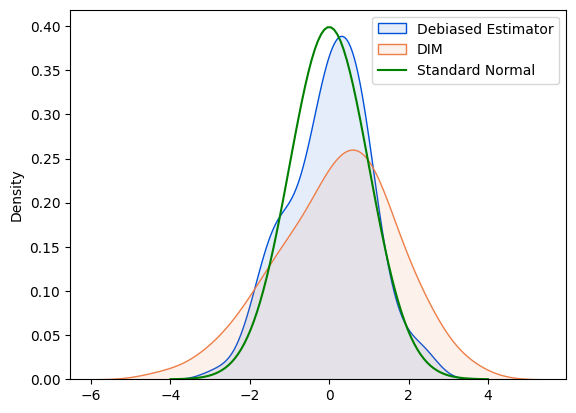

In [32]:
import seaborn as sns
sns.kdeplot(debias_B /np.sqrt(np.array(debias_var_B) / 6000), shade = True,color=tencent_blue,label = "Debiased Estimator",alpha=0.1)
sns.kdeplot(dim_B / np.sqrt(dim_var_B), shade = True,color=tencent_orange,label = "DIM",alpha=0.1)
plt.plot(x, y_standard_normal, color='green', label="Standard Normal")
plt.legend()
plt.savefig("AA_tstatistic_distribution_new.png")